In [1]:
%cd ../

/scratch/km817/iREC


In [2]:
import numpy as np
import pandas as pd
np.random.seed(0)
#!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate
!curl -O "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11487  100 11487    0     0  40164      0 --:--:-- --:--:-- --:--:-- 40164


(306, 7)

In [101]:
import matplotlib.pyplot as plt
import torch
import pyro
from torch import nn
import pyro.distributions as dist
from pyro.infer import HMC, MCMC, SVI, NUTS, TraceMeanField_ELBO
from pyro import poutine
from sklearn.datasets import load_boston
import numpy as np
import torch.nn.functional as F
from tqdm.notebook import trange
from rec.utils import kl_estimate_with_mc

In [31]:
x_ = data[:, :-1]
y_ = data[:, -1]
N_tr = int(x_.shape[0] * 0.66)
N_val = x_.shape[0] - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size=N_tr, replace=False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train - x_m) / x_s
x_val = (x_val - x_m) / x_s

D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)

In [32]:
y_val.shape

torch.Size([105])

In [52]:
def regression_model(x, y=None, weight_samples=None, in_size=6, num_nodes=10, out_size=1, ELBO_BETA=1.):
    # sample vector of weights for regression
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    # sample params
    params = pyro.sample("params", dist.Normal(torch.zeros(total_weights + 1), 1.).to_event(1))
    weights, rho = params[:-1], params[-1]

    idx = 0
    fc1_weights = weights[idx: idx + in_size * num_nodes].reshape(num_nodes, in_size)
    idx += in_size * num_nodes
    fc1_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc2_weights = weights[idx: idx + num_nodes * num_nodes].reshape(num_nodes, num_nodes)
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc3_weights = weights[idx: idx + num_nodes * out_size].reshape(out_size, num_nodes)
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size].reshape(out_size)
    idx += out_size

    assert idx == total_weights, "Something wrong with number of weights!"

    # compute forward pass
    batch_shape = x.shape[0]
    x = torch.einsum("ij, kj -> ki", fc1_weights, x) + fc1_bias[None].repeat(batch_shape, 1)
    x = torch.tanh(x)

    x = torch.einsum("ij, kj -> ki", fc2_weights, x) + fc2_bias[None].repeat(batch_shape, 1)
    x = torch.tanh(x)

    x = torch.einsum("ij, kj -> ki", fc3_weights, x) + fc3_bias[None].repeat(batch_shape, 1)
    mu = x.squeeze()

    with pyro.plate("data", x.shape[0]):
        with poutine.scale(None, ELBO_BETA ** -1):
            obs = pyro.sample("obs", dist.Normal(mu, F.softplus(rho)), obs=y)
    return mu


def KDE_guide(x, y=None, weight_samples=None, in_size=6, num_nodes=10, out_size=1, ELBO_BETA=None):
    total_weights = (in_size + 1) * num_nodes + (num_nodes + 1) * num_nodes + (num_nodes + 1) * out_size
    iso_noise = pyro.param("iso_noise", torch.tensor(1e-3), constraint=dist.constraints.positive)
    assignment = dist.Categorical(probs=torch.ones(weight_samples.shape[0])).sample()

    # sample assigmnent
    params = pyro.sample("params", dist.Normal(weight_samples[assignment], iso_noise).to_event(1))

    weights, rho = params[:-1], params[-1]
    idx = 0
    fc1_weights = weights[idx: idx + in_size * num_nodes].reshape(num_nodes, in_size)
    idx += in_size * num_nodes
    fc1_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc2_weights = weights[idx: idx + num_nodes * num_nodes].reshape(num_nodes, num_nodes)
    idx += num_nodes * num_nodes
    fc2_bias = weights[idx: idx + num_nodes].reshape(num_nodes)
    idx += num_nodes

    fc3_weights = weights[idx: idx + num_nodes * out_size].reshape(out_size, num_nodes)
    idx += num_nodes * out_size
    fc3_bias = weights[idx: idx + out_size].reshape(out_size)
    idx += out_size

    assert idx == total_weights, "Something wrong with number of weights!"

    # compute forward pass
    batch_shape = x.shape[0]
    x = torch.einsum("ij, kj -> ki", fc1_weights, x) + fc1_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc2_weights, x) + fc2_bias[None].repeat(batch_shape, 1)
    x = torch.relu(x)

    x = torch.einsum("ij, kj -> ki", fc3_weights, x) + fc3_bias[None].repeat(batch_shape, 1)
    mu = x.squeeze()


def make_empirical_gmm(samples, num_nodes):
    rho_noise = samples['params'][:, -1]
    noise = F.softplus(rho_noise)
    preds_dict = Predictive(regression_model, samples, return_sites=['obs'])(x_val, None, num_nodes=num_nodes, in_size=D_in)
    preds = preds_dict['obs']
    mix = dist.Categorical(torch.ones(preds.shape[0]))
    comp = dist.Normal(loc=preds.squeeze().permute(1, 0), scale=noise)
    gmm = dist.MixtureSameFamily(mix, comp)
    return gmm


In [86]:
pyro.set_rng_seed(10)
ELBO_BETA = 1.

in_size = x_train.shape[-1]
out_size = 1
num_nodes = 20

In [98]:
# run HMC
kernel = HMC(regression_model, step_size=0.001, num_steps=5, target_accept_prob=0.8)
nuts_kernel = NUTS(regression_model, step_size=0.5, max_tree_depth=5)
mcmc = MCMC(kernel, num_samples=1000, warmup_steps=1000, num_chains=1)
mcmc.run(x_train, y_train, ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in)

full_samples = mcmc.get_samples(100)
from pyro.infer import Predictive
pred = Predictive(regression_model, full_samples, return_sites=['obs'])(x_val, None, 
                                                                        num_nodes=num_nodes, in_size=D_in)
HMC_RMSE = ((pred['obs'].mean(0) - y_val) ** 2).mean().sqrt()

Sample: 100%|██████████| 2000/2000 [00:03, 527.76it/s, step size=7.55e-02, acc. prob=0.617]


In [99]:
optimizer = pyro.optim.Adam({"lr": 5e-3})

# train KDE
svi = SVI(regression_model, KDE_guide, optimizer, loss=TraceMeanField_ELBO())

num_iterations = 2500
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train, full_samples['params'], ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))

kde_noise = pyro.param("iso_noise")
flattened_params = full_samples['params']
kde_mix = dist.Categorical(probs=torch.ones(flattened_params.shape[0]))
kde_comps = dist.MultivariateNormal(loc=flattened_params,
                                    covariance_matrix=kde_noise * torch.eye(flattened_params.shape[-1]))
kde = dist.MixtureSameFamily(kde_mix, kde_comps)
prior = dist.MultivariateNormal(loc=torch.ones_like(flattened_params[0]),
                                covariance_matrix=torch.eye(flattened_params[0].shape[-1]))
kl_kde_prior = kl_estimate_with_mc(kde, prior)
kde_sample = kde.sample((100,))
kde_samples = {"params" : kde_sample}
kde_pred = Predictive(regression_model, kde_samples, return_sites=['obs', '_RETURN'])(x_val, None, 
                                                                        num_nodes=num_nodes, in_size=D_in)
KDE_RMSE = ((kde_pred['obs'].mean(0) - y_val) ** 2).mean().sqrt()

  0%|          | 0/2500 [00:00<?, ?it/s]

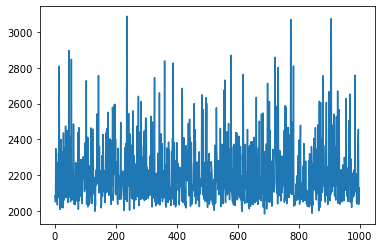

In [103]:
plt.plot(losses[-100:])

In [104]:
# train Factored Gaussian approx
optimizer = pyro.optim.Adam({"lr": 5e-3})
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(regression_model)
svi = SVI(regression_model, guide, optimizer, loss=TraceMeanField_ELBO())
num_iterations = 5000
pyro.clear_param_store()
pbar = trange(num_iterations)
losses = []
for j in pbar:
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train, ELBO_BETA=ELBO_BETA, num_nodes=num_nodes, in_size=D_in)
    losses.append(loss)
    pbar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

means, stds = params
variational_posterior = dist.MultivariateNormal(loc=means, covariance_matrix=torch.diag(stds ** 2))
variational_sample = variational_posterior.sample((100,))
variational_samples = {"params" : variational_sample}
kl_var_prior = kl_estimate_with_mc(variational_posterior, prior)
var_pred = Predictive(regression_model, variational_samples, return_sites=['obs', '_RETURN'])(x_val, None, 
                                                                        num_nodes=num_nodes, in_size=D_in)
VAR_RMSE = ((var_pred['obs'].mean(0) - y_val) ** 2).mean().sqrt()

  0%|          | 0/5000 [00:00<?, ?it/s]

Warmup:   1%|          | 188/20000 [47:51, 15.27s/it, step size=1.41e-03, acc. prob=0.766]


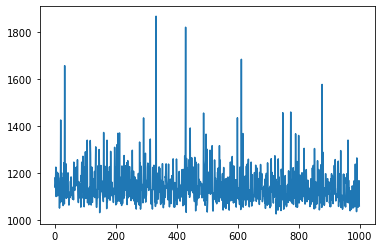

In [114]:
plt.plot(losses[-1000:])

In [96]:
hmc_gmm = make_empirical_gmm(full_samples, num_nodes)
kde_gmm = make_empirical_gmm(kde_samples, num_nodes)
var_gmm = make_empirical_gmm(variational_samples, num_nodes)
print(f"The final KLs are: KDE {kl_kde_prior}, VAR {kl_var_prior}\n"
      f"The final RMSE are: HMC {HMC_RMSE}, KDE {KDE_RMSE}, VAR {VAR_RMSE}\n"
      f"The final LLs are: HMC {hmc_gmm.log_prob(y_val).sum()}, KDE {kde_gmm.log_prob(y_val).sum()}, VAR {var_gmm.log_prob(y_val).sum()}.")

The final KLs are: KDE 2202.363037109375, VAR 880.0399780273438
The final RMSE are: HMC 1.3046051263809204, KDE 1.2810133695602417, VAR 1.068897008895874
The final LLs are: HMC -25483.751953125, KDE -543.1305541992188, VAR -225.5260772705078.


In [97]:
means.shape

torch.Size([582])